# Fitting the Bayesian DML model by Frank & Laura (2024)

I want to replicate the following STAN model:

```
data {
  int<lower=1> J;
  int<lower=0> N;
  array[N] vector[J] x;
  array[N] vector[2] y;
}
parameters {
  matrix[2, J] beta;
  cholesky_factor_corr[2] L_Omega;
  vector<lower=0>[2] L_sigma;
  vector<lower=0>[2] sigma_beta;  // Different standard deviations for beta rows
}
model {
  array[N] vector[2] mu;
  matrix[2, 2] L_Sigma;

  for (n in 1:N) {
    mu[n] = beta * x[n];
  }

  L_Sigma = diag_pre_multiply(L_sigma, L_Omega);

  // Separate priors for each row of beta
  beta[1] ~ normal(0, sigma_beta[1]);
  beta[2] ~ normal(0, sigma_beta[2]);
  sigma_beta ~ inv_gamma(2, 2);

  L_Omega ~ lkj_corr_cholesky(4);
  L_sigma ~ cauchy(0, 2.5);

  y ~ multi_normal_cholesky(mu, L_Sigma);
}
generated quantities {
  real alpha;
  alpha = L_Omega[2,1] * L_sigma[1] / L_sigma[2];
}
```

Importing requires libraries:

In [1]:
import numpy as np
import bayesflow as bf
import matplotlib.pyplot as plt

/Users/lasse/miniconda3/envs/bayesflow/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
seed = 1999
RNG = np.random.default_rng(seed)

Defining the prior

In [3]:
# number of regressors
P = 5

def prior_func():
    # sample standard deviations sigma_beta from a inverse gamma (2,2)
    betas = []
    for _ in range(P):
        sigma_beta_1 = 1 / (RNG.gamma(2, 1/2))
        sigma_beta_2 = 1 / (RNG.gamma(2, 1/2))
        beta_1 = RNG.normal(0, sigma_beta_1)
        beta_2 = RNG.normal(0, sigma_beta_2)
        betas.append([beta_1, beta_2])
    # sample diagonal elements of the covariance matrix L_sigma 
    L_sigma_1 = RNG.standard_cauchy() * 2
    L_sigma_2 = RNG.standard_cauchy() * 2
    # sample lkj_cholesky correlation parameter
    rho = 2 * RNG.beta(4,4) - 1
    return np.concatenate([np.array(betas).flatten(), [L_sigma_1, L_sigma_2, rho]])

p = prior_func()
p

array([ 0.32816644, -0.28934035,  1.34761042, -0.20709734,  2.68826528,
        0.33532565, 14.39032795, -0.35379387, -0.2741655 ,  3.37576067,
        3.26662413,  2.44227516,  0.40710447])

In [4]:
prior = bf.simulation.Prior(prior_fun = prior_func)

In [5]:
def likelihood_func(params, n_obs = 100):
    assert(len(params) == P*2 + 3)
    # unflatten the first P*2 elements to get the betas
    betas = np.array(params[:P*2]).reshape(P,2)
    L_sigma_1 = params[P]
    L_sigma_2 = params[P+1]
    rho = params[P+2]
    # sample the covariance matrix
    L_Omega = np.array([
        [1, 0],
        [rho, np.sqrt(1 - rho**2)]
    ])
    Sigma = np.diag([L_sigma_1, L_sigma_2]).dot(L_Omega)
    # simulate x of dimension N x P = 5
    x = RNG.multivariate_normal(np.zeros(5), np.diag(np.ones(5)), n_obs) # N x P
    means = x.dot(betas) # 10 x 2
    # for each observation, sample the bivariate outcome y
    y = np.array([
        means[n] + Sigma.dot(np.random.randn(2))  # L_Sigma transforms standard normal
        for n in range(n_obs)
    ])
    # format as N x (P + 2)
    return np.concatenate([x, y], axis=1)

data = likelihood_func(prior_func(), n_obs = 10)
data.shape

/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_20099/1894031858.py:11: RuntimeWarning: invalid value encountered in sqrt
  [rho, np.sqrt(1 - rho**2)]


(10, 7)

In [6]:
simulator = bf.simulation.Simulator(simulator_fun=likelihood_func)
model = bf.simulation.GenerativeModel(prior = prior, simulator = simulator)

/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_20099/1894031858.py:11: RuntimeWarning: invalid value encountered in sqrt
  [rho, np.sqrt(1 - rho**2)]
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 13)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 7)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [7]:
%%time
out = model(batch_size=100)

CPU times: user 20.1 ms, sys: 3.16 ms, total: 23.2 ms
Wall time: 21.5 ms


/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_20099/1894031858.py:11: RuntimeWarning: invalid value encountered in sqrt
  [rho, np.sqrt(1 - rho**2)]


In [8]:
out["sim_data"].shape

(100, 100, 7)

In [9]:
# count all batches (axis 0) that have at least one NA
np.sum(np.all(np.isfinite(out["sim_data"]), axis = (1,2)))

58

Only 64% of batches go through. Some batches contain NA for numerical issues. We will need to adjust the configurator to filter those out.

In [10]:
summary_net = bf.networks.DeepSet(
    summary_dim = np.floor((2*P + 3)*1.5), # I will need to understand how to set this sensibly
)
inference_net = bf.networks.InvertibleNetwork(
    num_params = 2*P + 3,
    num_coupling_layers = 8,
    coupling_design="affine",
    coupling_settings={
        "dense_args": dict(kernel_regularizer=None), 
        "dropout": False, # no L2 and no dropout regularization since online simulation
    }, 
)

In [11]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

Now we define out configurator (essentially a form of preprocessing):

In [12]:
def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    sim_data = forward_dict["sim_data"]
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(sim_data), axis=(1, 2))

    # Add to keys
    out_dict["summary_conditions"] = sim_data[idx_keep]
    out_dict["parameters"] = forward_dict["prior_draws"][idx_keep]

    return out_dict

In [13]:
# using on our test data
out_configured = configure_input(out)
out_configured["summary_conditions"].shape

(58, 100, 7)

In [14]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [15]:
amortizer.summary()

Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  664176    
 ibleNetwork)                                                    
                                                                 
 deep_set (DeepSet)          multiple                  68691     
                                                                 
Total params: 732867 (2.80 MB)
Trainable params: 732659 (2.79 MB)
Non-trainable params: 208 (832.00 Byte)
_________________________________________________________________


Almost 3/4 million parameters to learn... Is this too many?

Since our model samples quite fast, I proceed with online training here. If instead I used offline training, I would need to put the regularization back in.

In [16]:
%%time
_ = model(32)

CPU times: user 7.91 ms, sys: 2.95 ms, total: 10.9 ms
Wall time: 9.83 ms


/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_20099/1894031858.py:11: RuntimeWarning: invalid value encountered in sqrt
  [rho, np.sqrt(1 - rho**2)]


In [17]:
%%time
history = trainer.train_online(epochs = 20, iterations_per_epoch=500, batch_size=256, validation_sims=200)

/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_20099/1894031858.py:11: RuntimeWarning: invalid value encountered in sqrt
  [rho, np.sqrt(1 - rho**2)]
INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 500/500 [00:58<00:00,  8.56it/s, Epoch: 1, Iter: 500,Loss: 24.712,Avg.Loss: 42810.352,LR: 4.97E-04]     
INFO:root:Validation, Epoch: 1, Loss: 25.201
Training epoch 2: 100%|██████████| 500/500 [00:49<00:00, 10.10it/s, Epoch: 2, Iter: 500,Loss: 22.772,Avg.Loss: 24.719,LR: 4.88E-04]
INFO:root:Validation, Epoch: 2, Loss: 24.378
Training epoch 3: 100%|██████████| 500/500 [00:49<00:00, 10.03it/s, Epoch: 3, Iter: 500,Loss: 22.626,Avg.Loss: 26.599,LR: 4.73E-04]  
INFO:root:Validation, Epoch: 3, Loss: 23.159
Training epoch 4: 100%|██████████| 500/500 [00:50<00:00,  9.96it/s, Epoch: 4, Iter: 500,Loss: 21.771,Avg.Loss: 22.923,LR: 4.52E-04] 
INFO:root:Validation, Epoch: 4, Loss: 22.571
Training epoch 5: 100%|██████████| 500/500 [00:50<00:00,  9.89it/s,

CPU times: user 26min 18s, sys: 6min 52s, total: 33min 10s
Wall time: 36min 32s


(0.0, 100.0)

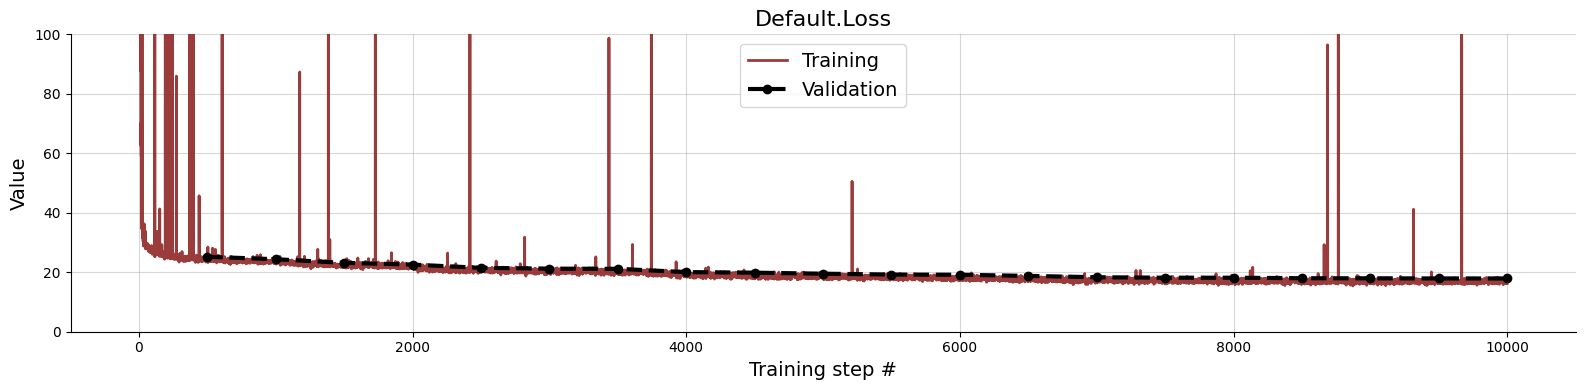

In [18]:
f = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)
plt.ylim(0,0.1e3)

In [19]:
# obtain posterior samples for dignostic checks
test_sims = trainer.configurator(model(500))
posterior_samples = amortizer.sample(test_sims, n_samples = 1000)
posterior_samples.shape

/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_20099/1894031858.py:11: RuntimeWarning: invalid value encountered in sqrt
  [rho, np.sqrt(1 - rho**2)]


(292, 1000, 13)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


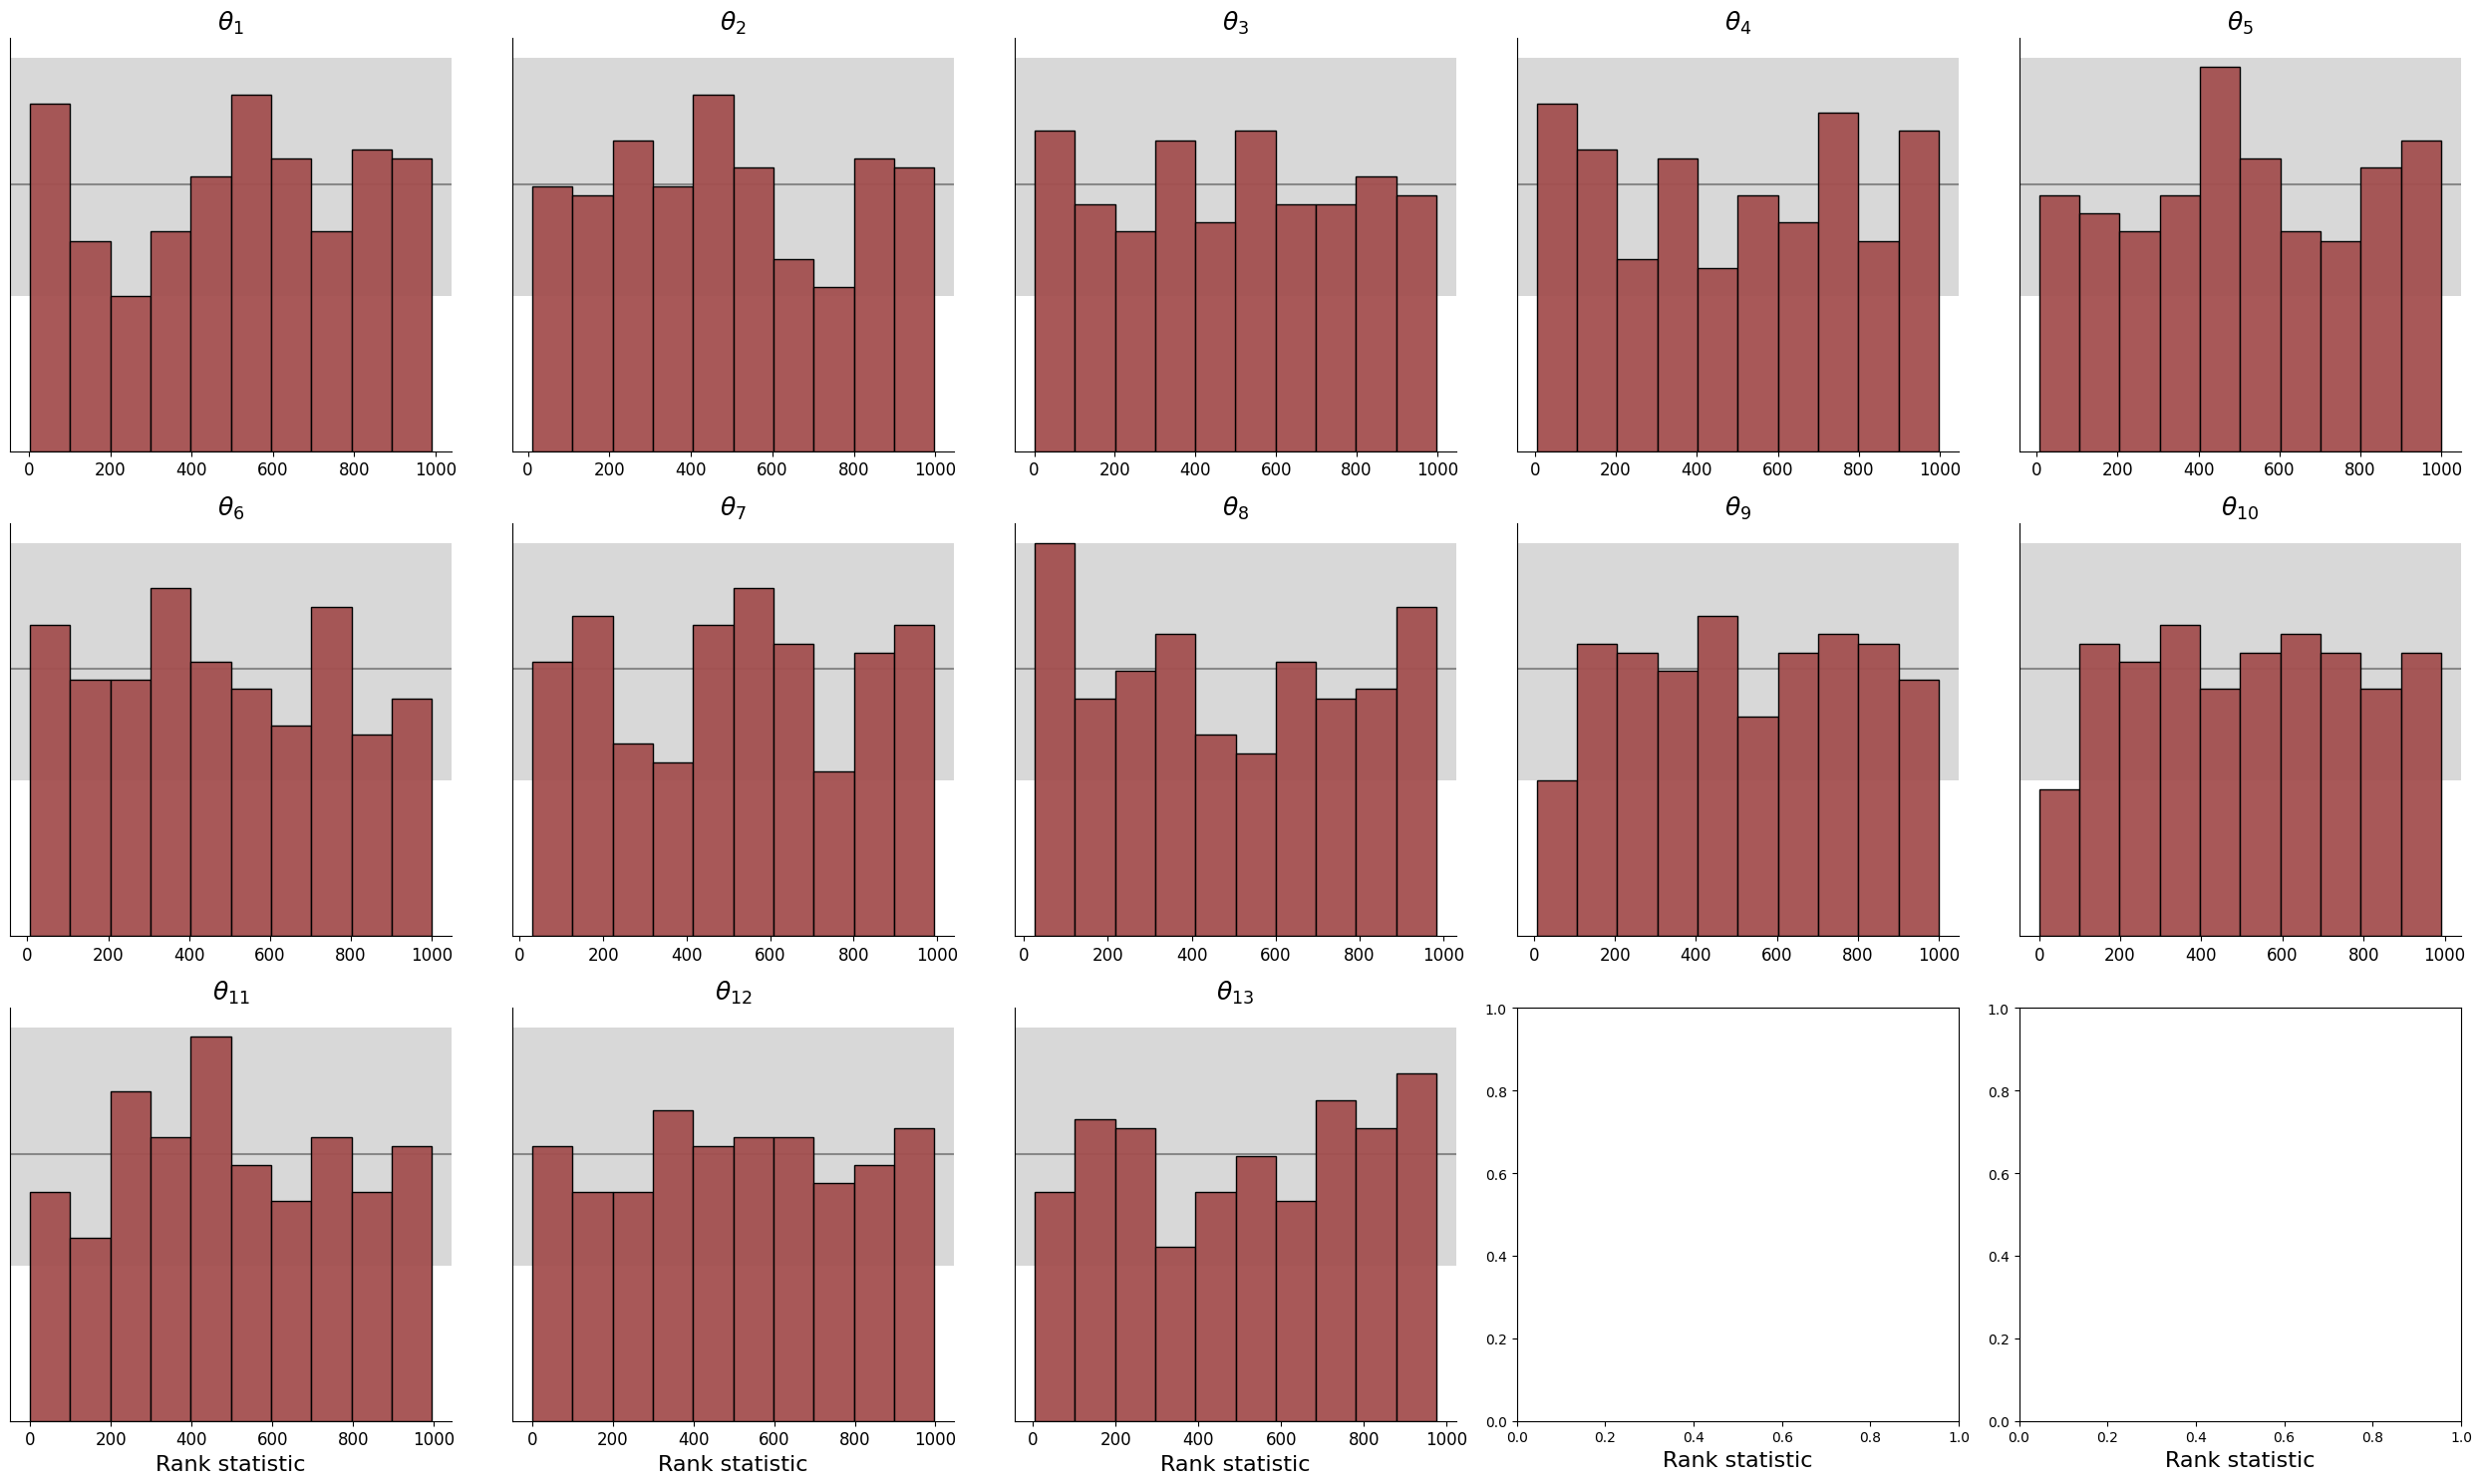

In [20]:
f = bf.diagnostics.plot_sbc_histograms(posterior_samples, test_sims["parameters"], num_bins = 10)

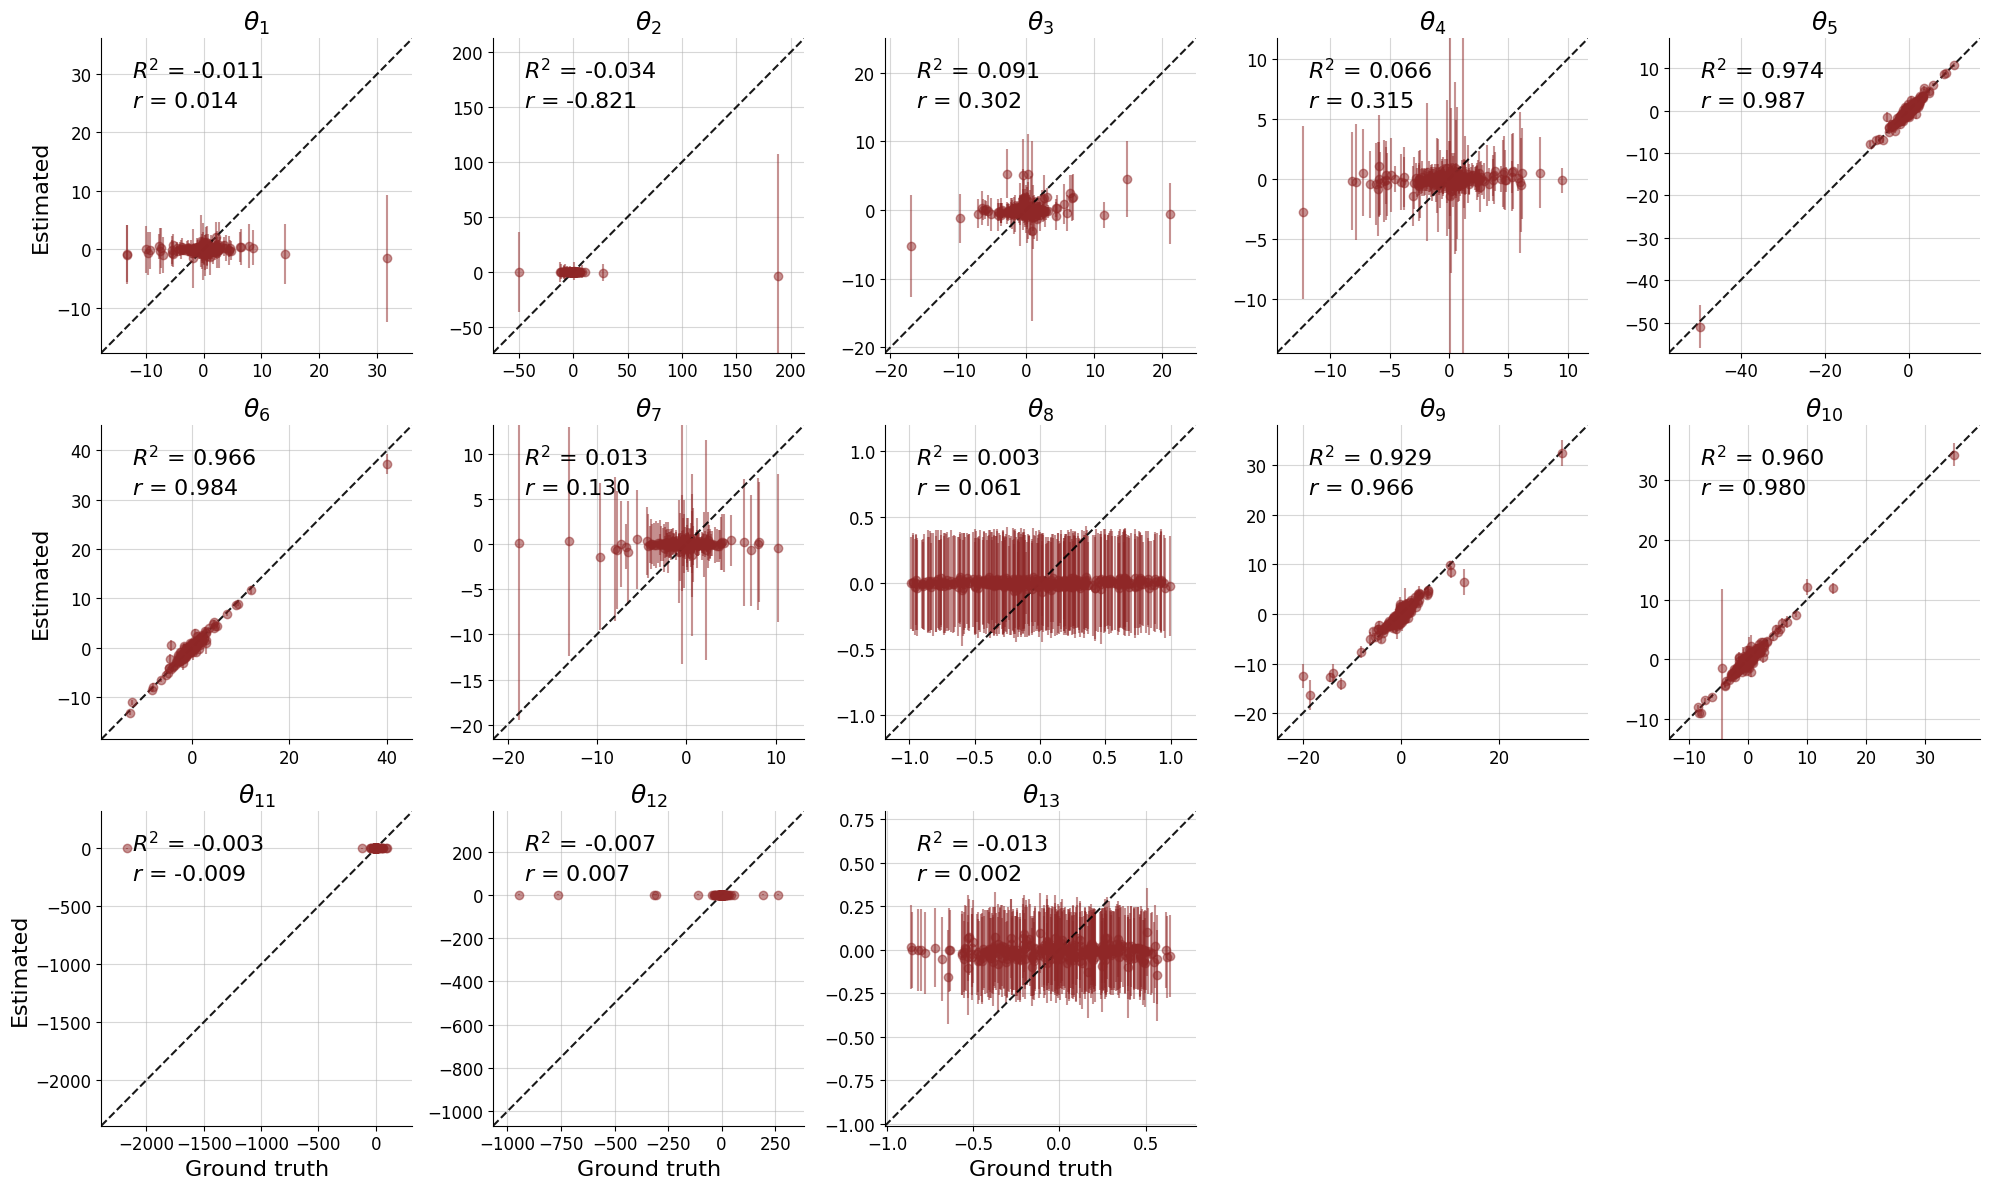

In [21]:
f = bf.diagnostics.plot_recovery(posterior_samples, test_sims["parameters"])

Some parameters actually work very nicely. Some other seems to not yet be learned at all... Perhaps I just need more training...?

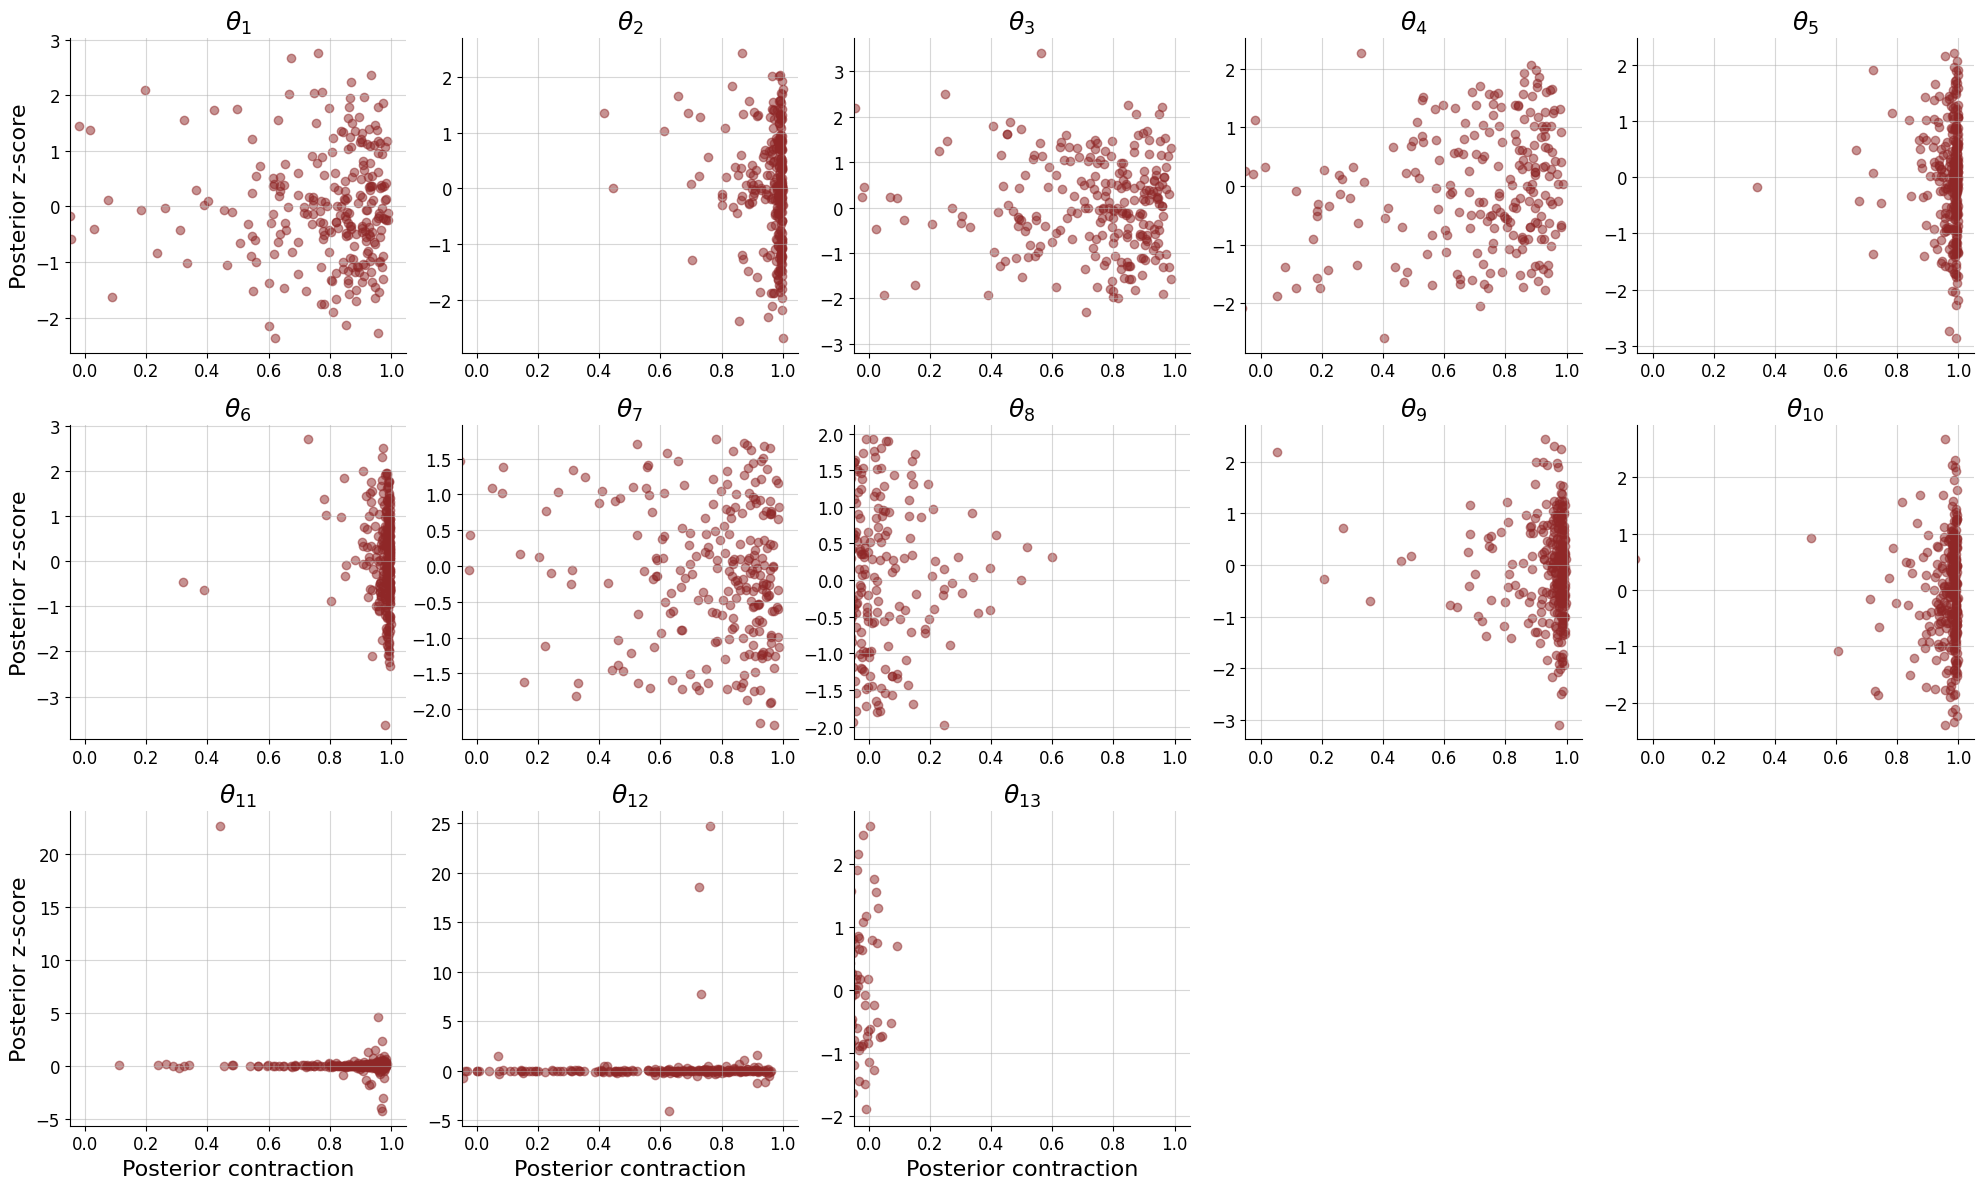

In [22]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, test_sims["parameters"])

To obtain posterior samples for $\alpha$, we need to transform the samples of the last 3 parameters.